In [1]:
import numpy as np
import time
import pickle
import os
import matplotlib.pyplot as plt
import warnings
import pandas as pd

warnings.filterwarnings('ignore')

In [2]:
print("----------------Reading the Data-------------------------")
PATH = os.getcwd()
os.chdir('Alphabets/')

X_train = pd.read_csv('train.csv', sep=',', header=None, index_col=False)
X_test = pd.read_csv('test.csv', sep=',', header=None, index_col=False)
np.random.shuffle(X_train.to_numpy())
train_class = X_train[X_train.columns[-1]]
test_actual_class = X_test[X_test.columns[-1]]

X_train = X_train.drop(X_train.columns[-1], axis=1)
X_test = X_test.drop(X_test.columns[-1], axis=1)

print("----------------Data Reading completed-------------------")

os.chdir('../')

X_train = X_train/255
X_test = X_test/255

m = X_train.shape[0] # Number of Training Samples

# X_valid = X_train.iloc[(int(0.85*m)):]
# valid_class = train_class[(int(0.85*m)):]
# X_train = X_train.iloc[0:int(0.85*m)]
# train_class = train_class[0:int(0.85*m)]


m = X_train.shape[0] # Number of Training Samples
n = X_train.shape[1] # Number of input features

print("The total number of training samples = {}".format(m))
#print("The total number of validation samples = {}".format(X_valid.shape[0]))

print("The number of features = {}".format(n))

----------------Reading the Data-------------------------
----------------Data Reading completed-------------------
The total number of training samples = 13000
The number of features = 784


In [3]:
#To get the one hot encoding of each label
print("--------Perform 1-hot encoding of class labels------------")

train_class_enc = pd.get_dummies(train_class).to_numpy()
#valid_class_enc = pd.get_dummies(valid_class).to_numpy()
test_actual_class_enc = pd.get_dummies(test_actual_class).to_numpy()

--------Perform 1-hot encoding of class labels------------


In [4]:
#Add the intercept term to the data samples both in training and test dataset
X_train = np.hstack((np.ones((m,1)),X_train.to_numpy()))
#X_valid = np.hstack((np.ones((X_valid.shape[0],1)), X_valid.to_numpy()))
X_test = np.hstack((np.ones((X_test.shape[0],1)),X_test.to_numpy()))

In [5]:
lr = 0.1
arch_test = [1,5,10,50,100]
arch = [arch_test[3]] #means one hidden layer with 2 perceptrons 
batch_size = 100 # Mini-Batch Size
r = np.max(train_class) + 1 # Default value of the number of classes = 26

In [6]:
#Mini-Batch formation
mini_batch = [(X_train[i:i+batch_size,:], train_class_enc[i:i+batch_size]) for i in range(0, m, batch_size)]
print("The number of mini-batches formed is = {}".format(len(mini_batch)))

The number of mini-batches formed is = 130


In [7]:
#Theta Initialization 
np.random.seed(1)
def theta_init(arch=[50]):
    theta = []
    for i in range(len(arch)+1):
        if i == 0:
            dim0=n+1
            dim1=arch[i]
        elif (i == len(arch)):
            dim0=arch[i-1]
            dim1 = r
        else:
            dim0=arch[i-1]
            dim1= arch[i]

        theta.append(0.01*(2*np.random.random((dim0, dim1))-1))
        #theta.append(np.zeros((dim0, dim1)))
    return theta

In [8]:
def activation(x):
    return 1/(1+np.exp(-x))

In [9]:
def relu_act(x):
#     x[x<=0] = 0.01*x[x<=0]
#     return x
    return np.maximum(0.0, x)

In [10]:
def softplus(x):
    return np.log(1+np.exp(x))

In [11]:
def deriv_softplus(x):
    return 1/(1+np.exp(-x))

In [12]:
def deriv_relu(x):
    #x[x<=0] = -0.01
    x[x<=0] = 0
    x[x>0] = 1
    return x

In [13]:
a = np.array([[1,-1,0], [-2.5, 0, 3]])
print(softplus(a))
print(deriv_softplus(a))

[[1.31326169 0.31326169 0.69314718]
 [0.07888973 0.69314718 3.04858735]]
[[0.73105858 0.26894142 0.5       ]
 [0.07585818 0.5        0.95257413]]


In [14]:
def forward_prop(data, theta):
    fm = []
    fm.append(data)
    for l in range(len(theta)):
        if (l != len(theta)-1):
            #print("relu")
            fm.append(relu_act(np.dot(fm[l], theta[l])))
        else:
            fm.append(activation(np.dot(fm[l], theta[l])))
            #print("sigmoid output")
    return fm

In [18]:
theta = theta_init([100, 100, 100])
print(theta[3].shape)
cost_total(X_train, theta, train_class_enc, m)
#fm = forward_prop(X_train, theta)

(100, 26)


3.2500020553563362

In [17]:
def cost_total(X, theta, Y, m):
    fm = forward_prop(X, theta)
    cost = (1/(2*m))*np.sum((Y-fm[-1])**2)
    return cost

In [19]:
def calc_accuracy(data, theta, actual_class):
    pred_class = forward_prop(data, theta)
    test_pred_class = pred_class[-1]
    for i in range(len(test_pred_class)):
        test_pred_class[i][test_pred_class[i] == np.max(test_pred_class[i])] = 1
        test_pred_class[i][test_pred_class[i] != np.max(test_pred_class[i])] = 0


    test_acc = 0
    for i in range(len(actual_class)):
        if (np.array_equal(test_pred_class[i], actual_class[i])):
            test_acc+=1
    test_acc /= data.shape[0]

    #print("The Test Accuracy of the model = {}%".format(test_acc*100))
    return (test_acc*100)

In [20]:
epochs = []
train_accuracy = []
test_accuracy = []
train_time = []
valid_accuracy=[]

In [32]:
arch=[100, 100]
lr0=0.1
#lr = 0.01
theta = theta_init(arch)
print(theta[0].shape, theta[1].shape, theta[2].shape)

(785, 100) (100, 100) (100, 26)


In [33]:
costs = []
epoch = 1
start = time.time()
cost_init = cost_total(X_train, theta, train_class_enc, m) #Validation loss not giving much info
costs.append(cost_init)
while(True):
    count = 0
    lr = lr0/(np.power(epoch, 1/3))
    #if(lr < 0.001): lr = 0.001
    print("learning rate = ", lr)

    print("Initial Cost on Val dataset for this epoch {} = {}".format(epoch, cost_init))

    for b in mini_batch:
        X_b = b[0]
        Y_b = b[1]
        fm = forward_prop(X_b, theta)
        delta = [None]*len(fm)

        if (count % 60 == 0):
            print("Error on this batch = "+str(cost_total(X_b, theta, Y_b, batch_size)))
        #Backward Propagation

        for l in range(len(fm)-1, 0, -1):
            if (l == len(fm)-1):
                delta[l] = ((1/batch_size)*(Y_b - fm[l])*fm[l]*(1-fm[l]))
                #print("delta for last layer=",delta[l])
            else:
                delta[l]=(np.dot(delta[l+1], theta[l].T)*deriv_relu(fm[l]))
                #print("delta for hidden layer=",np.mean(delta[l]))

        for t in range(len(theta)):
            theta[t] += lr*np.dot(fm[t].T, delta[t+1]) 
        
        count+=1
    epoch+=1 #Number of epochs
    #ite+=1

    cost_final = cost_total(X_train, theta, train_class_enc, m)
    if(epoch%10==0): costs.append(cost_final)
    print("Cost on val dataset after {} epochs is = {}".format(epoch, cost_final))
    if (abs(cost_final-cost_init) < 1e-08):
        print("cost initial= {} , cost final={} , change in cost= {}".format(cost_init,cost_final, cost_final-cost_init))
        break
    cost_init = cost_final
epochs.append(epoch)
train_time.append(time.time()-start)
train_accuracy.append(calc_accuracy(X_train, theta, train_class_enc))
#valid_accuracy.append(calc_accuracy(X_valid, theta, valid_class_enc))
test_accuracy.append(calc_accuracy(X_test, theta, test_actual_class_enc))
print("\n------------------------------------------------------------------------------")
print("The stats for number of units in the hidden layer arch= {} are as below:".format(arch))
print("------------------------------------------------------------------------------")
print("The number of epochs = {:2.3f}".format(epochs[-1]))
print("The training time = {:2.3f}sec".format(train_time[-1]))
print("The training accuracy is = {:2.3f}%".format(train_accuracy[-1]))
#print("The validation accuracy is = {:2.3f}%".format(valid_accuracy[-1]))
print("The test accuracy is = {:2.3f}%".format(test_accuracy[-1]))
print("------------------------------------------------------------------------------\n")

learning rate =  0.1
Initial Cost on Val dataset for this epoch 1 = 3.250087007443555
Error on this batch = 3.250085566858839
Error on this batch = 0.49179107155400986
Error on this batch = 0.49063800934939245
Cost on val dataset after 2 epochs is = 0.4904522797375815
learning rate =  0.07937005259840997
Initial Cost on Val dataset for this epoch 2 = 0.4904522797375815
Error on this batch = 0.4904607822312401
Error on this batch = 0.4897575297572509
Error on this batch = 0.4896877150184538
Cost on val dataset after 3 epochs is = 0.4898438251393698
learning rate =  0.06933612743506348
Initial Cost on Val dataset for this epoch 3 = 0.4898438251393698
Error on this batch = 0.48946918425927777
Error on this batch = 0.48898800728553926
Error on this batch = 0.4892613920271198
Cost on val dataset after 4 epochs is = 0.48952351462379917
learning rate =  0.06299605249474366
Initial Cost on Val dataset for this epoch 4 = 0.48952351462379917
Error on this batch = 0.48886769907759475
Error on thi

Error on this batch = 0.4826134427268414
Error on this batch = 0.48253521424546164
Cost on val dataset after 30 epochs is = 0.48333700975096033
learning rate =  0.03218297948685433
Initial Cost on Val dataset for this epoch 30 = 0.48333700975096033
Error on this batch = 0.4824211591040259
Error on this batch = 0.48239336036096075
Error on this batch = 0.4823128655281921
Cost on val dataset after 31 epochs is = 0.483110910595848
learning rate =  0.03183313678457734
Initial Cost on Val dataset for this epoch 31 = 0.483110910595848
Error on this batch = 0.48223348809634325
Error on this batch = 0.48218427995497615
Error on this batch = 0.4821058041245817
Cost on val dataset after 32 epochs is = 0.4828974065072472
learning rate =  0.03149802624737183
Initial Cost on Val dataset for this epoch 32 = 0.4828974065072472
Error on this batch = 0.4820563720222307
Error on this batch = 0.4819871042273578
Error on this batch = 0.4819146740062032
Cost on val dataset after 33 epochs is = 0.4826972112

Error on this batch = 0.480607893988937
Error on this batch = 0.4805808668211495
Cost on val dataset after 59 epochs is = 0.4808645471778045
learning rate =  0.025687154396613652
Initial Cost on Val dataset for this epoch 59 = 0.4808645471778045
Error on this batch = 0.4807001626969648
Error on this batch = 0.48061426477743513
Error on this batch = 0.4805875933317462
Cost on val dataset after 60 epochs is = 0.48085393381812275
learning rate =  0.02554364774645177
Initial Cost on Val dataset for this epoch 60 = 0.48085393381812275
Error on this batch = 0.4807016552312258
Error on this batch = 0.48062105027735164
Error on this batch = 0.4805948660360322
Cost on val dataset after 61 epochs is = 0.48084455263682574
learning rate =  0.02540329520093663
Initial Cost on Val dataset for this epoch 61 = 0.48084455263682574
Error on this batch = 0.48070349893661063
Error on this batch = 0.4806281174987591
Error on this batch = 0.48060252888352295
Cost on val dataset after 62 epochs is = 0.480836

Error on this batch = 0.48075571943273504
Error on this batch = 0.4807453820401699
Cost on val dataset after 88 epochs is = 0.48077345952069517
learning rate =  0.022482215651130462
Initial Cost on Val dataset for this epoch 88 = 0.48077345952069517
Error on this batch = 0.48074987213910936
Error on this batch = 0.4807576984149516
Error on this batch = 0.480747624087159
Cost on val dataset after 89 epochs is = 0.48077296082542814
learning rate =  0.02239769524555751
Initial Cost on Val dataset for this epoch 89 = 0.48077296082542814
Error on this batch = 0.48075055870073974
Error on this batch = 0.48075953650723774
Error on this batch = 0.48074970862587707
Cost on val dataset after 90 epochs is = 0.48077249422208007
learning rate =  0.022314431669405655
Initial Cost on Val dataset for this epoch 90 = 0.48077249422208007
Error on this batch = 0.480751196271629
Error on this batch = 0.4807612421402773
Error on this batch = 0.48075164545121973
Cost on val dataset after 91 epochs is = 0.48

Error on this batch = 0.48077209801948334
Cost on val dataset after 116 epochs is = 0.48076563579983594
learning rate =  0.020504412815784637
Initial Cost on Val dataset for this epoch 116 = 0.48076563579983594
Error on this batch = 0.480758136997971
Error on this batch = 0.48077910815488234
Error on this batch = 0.48077230861925485
Cost on val dataset after 117 epochs is = 0.4807654665600124
learning rate =  0.02044582845988404
Initial Cost on Val dataset for this epoch 117 = 0.4807654665600124
Error on this batch = 0.4807582047651562
Error on this batch = 0.48077926408968924
Error on this batch = 0.4807724977984482
Cost on val dataset after 118 epochs is = 0.4807653005137504
learning rate =  0.020387907955627036
Initial Cost on Val dataset for this epoch 118 = 0.4807653005137504
Error on this batch = 0.48075826448023895
Error on this batch = 0.480779401581853
Error on this batch = 0.4807726665740502
Cost on val dataset after 119 epochs is = 0.4807651372162943
learning rate =  0.02033

Error on this batch = 0.48077930203280744
Error on this batch = 0.48077241680446964
Cost on val dataset after 145 epochs is = 0.48076105011001796
learning rate =  0.01903461071310655
Initial Cost on Val dataset for this epoch 145 = 0.48076105011001796
Error on this batch = 0.4807574479361986
Error on this batch = 0.4807792545587279
Error on this batch = 0.4807723415485258
Cost on val dataset after 146 epochs is = 0.4807609272933126
learning rate =  0.01899105309928761
Initial Cost on Val dataset for this epoch 146 = 0.4807609272933126
Error on this batch = 0.4807574029602185
Error on this batch = 0.4807792049570532
Error on this batch = 0.4807722631316398
Cost on val dataset after 147 epochs is = 0.48076080557958567
learning rate =  0.018947891466173296
Initial Cost on Val dataset for this epoch 147 = 0.48076080557958567
Error on this batch = 0.4807573568755029
Error on this batch = 0.48077915328558385
Error on this batch = 0.48077218195094956
Cost on val dataset after 148 epochs is = 

Error on this batch = 0.48076961016452174
Cost on val dataset after 173 epochs is = 0.4807578768635144
learning rate =  0.017946701204829035
Initial Cost on Val dataset for this epoch 173 = 0.4807578768635144
Error on this batch = 0.4807557073384705
Error on this batch = 0.4807773865012454
Error on this batch = 0.480769495372126
Cost on val dataset after 174 epochs is = 0.48075777013005566
learning rate =  0.01791225447675807
Initial Cost on Val dataset for this epoch 174 = 0.48075777013005566
Error on this batch = 0.4807556307079179
Error on this batch = 0.4807773123545407
Error on this batch = 0.480769380277042
Cost on val dataset after 175 epochs is = 0.48075766366568917
learning rate =  0.017878070701931353
Initial Cost on Val dataset for this epoch 175 = 0.48075766366568917
Error on this batch = 0.48075555329970954
Error on this batch = 0.48077723831940183
Error on this batch = 0.4807692643779721
Cost on val dataset after 176 epochs is = 0.48075755753400923
learning rate =  0.0178

Error on this batch = 0.48077518784764683
Error on this batch = 0.4807659876157611
Cost on val dataset after 202 epochs is = 0.4807546926509953
learning rate =  0.01704313733210296
Initial Cost on Val dataset for this epoch 202 = 0.4807546926509953
Error on this batch = 0.48075305977326904
Error on this batch = 0.48077508799551516
Error on this batch = 0.4807657696464102
Cost on val dataset after 203 epochs is = 0.4807545143521931
learning rate =  0.01701510580563294
Initial Cost on Val dataset for this epoch 203 = 0.4807545143521931
Error on this batch = 0.4807528817407603
Error on this batch = 0.4807749881386367
Error on this batch = 0.4807655540507841
Cost on val dataset after 204 epochs is = 0.4807543327881083
learning rate =  0.016987257792186555
Initial Cost on Val dataset for this epoch 204 = 0.4807543327881083
Error on this batch = 0.4807527036150759
Error on this batch = 0.480774900195763
Error on this batch = 0.48076534421898737
Cost on val dataset after 205 epochs is = 0.480

Error on this batch = 0.48076156523657904
Cost on val dataset after 230 epochs is = 0.4807511362192921
learning rate =  0.01632139923033617
Initial Cost on Val dataset for this epoch 230 = 0.4807511362192921
Error on this batch = 0.48074960834418556
Error on this batch = 0.4807727837873303
Error on this batch = 0.48076142342847616
Cost on val dataset after 231 epochs is = 0.4807510206260054
learning rate =  0.016297813360438465
Initial Cost on Val dataset for this epoch 231 = 0.4807510206260054
Error on this batch = 0.4807494927240747
Error on this batch = 0.48077269677374007
Error on this batch = 0.4807612815589902
Cost on val dataset after 232 epochs is = 0.4807509048322355
learning rate =  0.016274363236883384
Initial Cost on Val dataset for this epoch 232 = 0.4807509048322355
Error on this batch = 0.480749376757573
Error on this batch = 0.4807726093040665
Error on this batch = 0.4807611396984353
Cost on val dataset after 233 epochs is = 0.4807507888531496
learning rate =  0.0162510

Cost on val dataset after 258 epochs is = 0.48074781338645833
learning rate =  0.015708212388755992
Initial Cost on Val dataset for this epoch 258 = 0.48074781338645833
Error on this batch = 0.4807460986742242
Error on this batch = 0.4807702751678872
Error on this batch = 0.48075730700916636
Cost on val dataset after 259 epochs is = 0.4807476906238117
learning rate =  0.01568796982459297
Initial Cost on Val dataset for this epoch 259 = 0.4807476906238117
Error on this batch = 0.48074596311815093
Error on this batch = 0.48077018196615684
Error on this batch = 0.48075715165007715
Cost on val dataset after 260 epochs is = 0.4807475675322986
learning rate =  0.015667831201909694
Initial Cost on Val dataset for this epoch 260 = 0.4807475675322986
Error on this batch = 0.4807458269384861
Error on this batch = 0.4807700884602774
Error on this batch = 0.4807569957102259
Cost on val dataset after 261 epochs is = 0.48074744412130577
learning rate =  0.015647795590281163
Initial Cost on Val datas

Error on this batch = 0.48076750138932994
Error on this batch = 0.48075282100950634
Cost on val dataset after 287 epochs is = 0.48074409541496294
learning rate =  0.015160238527102993
Initial Cost on Val dataset for this epoch 287 = 0.48074409541496294
Error on this batch = 0.4807417727534839
Error on this batch = 0.4807673961444104
Error on this batch = 0.48075265780068316
Cost on val dataset after 288 epochs is = 0.4807439606991077
learning rate =  0.015142671606934499
Initial Cost on Val dataset for this epoch 288 = 0.4807439606991077
Error on this batch = 0.4807416100139005
Error on this batch = 0.4807672906573901
Error on this batch = 0.4807524946166184
Cost on val dataset after 289 epochs is = 0.48074382549061756
learning rate =  0.015125185827401386
Initial Cost on Val dataset for this epoch 289 = 0.48074382549061756
Error on this batch = 0.48074144625012455
Error on this batch = 0.4807671849919354
Error on this batch = 0.48075233132566153
Cost on val dataset after 290 epochs is

Error on this batch = 0.4807481749016299
Cost on val dataset after 315 epochs is = 0.48074011901015046
learning rate =  0.014697037943612311
Initial Cost on Val dataset for this epoch 315 = 0.48074011901015046
Error on this batch = 0.4807368366342323
Error on this batch = 0.4807642912165326
Error on this batch = 0.48074800166986037
Cost on val dataset after 316 epochs is = 0.4807399669638427
learning rate =  0.014681518356627274
Initial Cost on Val dataset for this epoch 316 = 0.4807399669638427
Error on this batch = 0.48073663875512024
Error on this batch = 0.480764171385004
Error on this batch = 0.48074782657787807
Cost on val dataset after 317 epochs is = 0.48073981341583055
learning rate =  0.014666064115356299
Initial Cost on Val dataset for this epoch 317 = 0.48073981341583055
Error on this batch = 0.48073643700473784
Error on this batch = 0.480764049791375
Error on this batch = 0.4807476496166468
Cost on val dataset after 318 epochs is = 0.4807396581114854
learning rate =  0.014

Error on this batch = 0.4807596892378218
Error on this batch = 0.4807421067478127
Cost on val dataset after 344 epochs is = 0.48073425825134547
learning rate =  0.014271858104094724
Initial Cost on Val dataset for this epoch 344 = 0.48073425825134547
Error on this batch = 0.4807286484974184
Error on this batch = 0.4807595541262458
Error on this batch = 0.4807418954898858
Cost on val dataset after 345 epochs is = 0.480734058706523
learning rate =  0.014258055524783745
Initial Cost on Val dataset for this epoch 345 = 0.480734058706523
Error on this batch = 0.4807283754346429
Error on this batch = 0.4807594168483344
Error on this batch = 0.4807416834701077
Cost on val dataset after 346 epochs is = 0.48073385747717146
learning rate =  0.01424430618595228
Initial Cost on Val dataset for this epoch 346 = 0.48073385747717146
Error on this batch = 0.4807280992254402
Error on this batch = 0.4807592783670829
Error on this batch = 0.48074147105703063
Cost on val dataset after 347 epochs is = 0.48

Error on this batch = 0.48073536076222056
Cost on val dataset after 372 epochs is = 0.48072750671865844
learning rate =  0.013904403213142623
Initial Cost on Val dataset for this epoch 372 = 0.48072750671865844
Error on this batch = 0.4807192283147767
Error on this batch = 0.48075470139899545
Error on this batch = 0.4807351232250433
Cost on val dataset after 373 epochs is = 0.4807272614359146
learning rate =  0.013891966352111672
Initial Cost on Val dataset for this epoch 373 = 0.4807272614359146
Error on this batch = 0.4807188759997118
Error on this batch = 0.4807545374187472
Error on this batch = 0.48073488460931113
Cost on val dataset after 374 epochs is = 0.4807270147468295
learning rate =  0.013879573868859843
Initial Cost on Val dataset for this epoch 374 = 0.4807270147468295
Error on this batch = 0.480718521358871
Error on this batch = 0.48075437261808873
Error on this batch = 0.4807346451942955
Cost on val dataset after 375 epochs is = 0.4807267668998885
learning rate =  0.0138

Cost on val dataset after 400 epochs is = 0.4807194744875575
learning rate =  0.013572088082974535
Initial Cost on Val dataset for this epoch 400 = 0.4807194744875575
Error on this batch = 0.4807075070633377
Error on this batch = 0.48074963766663986
Error on this batch = 0.4807271098442986
Cost on val dataset after 401 epochs is = 0.48071911953514546
learning rate =  0.013560796823117574
Initial Cost on Val dataset for this epoch 401 = 0.48071911953514546
Error on this batch = 0.48070698332834966
Error on this batch = 0.48074944567358496
Error on this batch = 0.4807267607420331
Cost on val dataset after 402 epochs is = 0.48071877597227197
learning rate =  0.013549543044651297
Initial Cost on Val dataset for this epoch 402 = 0.48071877597227197
Error on this batch = 0.48070646725223287
Error on this batch = 0.480749253807318
Error on this batch = 0.4807264307017246
Cost on val dataset after 403 epochs is = 0.48071844009599213
learning rate =  0.013538326530381973
Initial Cost on Val dat

Error on this batch = 0.48074313309335537
Error on this batch = 0.4807175996798271
Cost on val dataset after 429 epochs is = 0.4807089323979907
learning rate =  0.0132591057968051
Initial Cost on Val dataset for this epoch 429 = 0.4807089323979907
Error on this batch = 0.48069116974189685
Error on this batch = 0.4807428736400725
Error on this batch = 0.48071722821697666
Cost on val dataset after 430 epochs is = 0.48070853455169815
learning rate =  0.013248819442174424
Initial Cost on Val dataset for this epoch 430 = 0.48070853455169815
Error on this batch = 0.48069052267713097
Error on this batch = 0.4807426130371966
Error on this batch = 0.48071685415398324
Cost on val dataset after 431 epochs is = 0.4807081347929071
learning rate =  0.013238564933865207
Initial Cost on Val dataset for this epoch 431 = 0.4807081347929071
Error on this batch = 0.4806898737058181
Error on this batch = 0.48074235134931387
Error on this batch = 0.48071647662355194
Cost on val dataset after 432 epochs is =

Error on this batch = 0.48070613071413165
Cost on val dataset after 457 epochs is = 0.4806967408468472
learning rate =  0.012982587748412776
Initial Cost on Val dataset for this epoch 457 = 0.4806967408468472
Error on this batch = 0.48067073718236486
Error on this batch = 0.4807349381995832
Error on this batch = 0.4807056796805231
Cost on val dataset after 458 epochs is = 0.4806962569686436
learning rate =  0.012973132109416915
Initial Cost on Val dataset for this epoch 458 = 0.4806962569686436
Error on this batch = 0.48066990243105645
Error on this batch = 0.48073462396636857
Error on this batch = 0.4807052256622217
Cost on val dataset after 459 epochs is = 0.48069576955933485
learning rate =  0.012963703957760678
Initial Cost on Val dataset for this epoch 459 = 0.48069576955933485
Error on this batch = 0.48066905955042233
Error on this batch = 0.4807343073148654
Error on this batch = 0.4807047690003263
Cost on val dataset after 460 epochs is = 0.4806952783628523
learning rate =  0.01

Error on this batch = 0.4807252341820183
Error on this batch = 0.4806917146094864
Cost on val dataset after 486 epochs is = 0.4806810356667731
learning rate =  0.012719047139481467
Initial Cost on Val dataset for this epoch 486 = 0.4806810356667731
Error on this batch = 0.4806427606432779
Error on this batch = 0.4807248493186452
Error on this batch = 0.48069116574517323
Cost on val dataset after 487 epochs is = 0.48068042737335415
learning rate =  0.012710335460632986
Initial Cost on Val dataset for this epoch 487 = 0.48068042737335415
Error on this batch = 0.48064164167185175
Error on this batch = 0.48072446141812225
Error on this batch = 0.480690612138913
Cost on val dataset after 488 epochs is = 0.48067981382532626
learning rate =  0.012701647600468317
Initial Cost on Val dataset for this epoch 488 = 0.48067981382532626
Error on this batch = 0.48064051186923595
Error on this batch = 0.48072407059738925
Error on this batch = 0.48069005495880207
Cost on val dataset after 489 epochs is

Error on this batch = 0.4806748182880419
Cost on val dataset after 514 epochs is = 0.48066202310936607
learning rate =  0.012483766215500817
Initial Cost on Val dataset for this epoch 514 = 0.48066202310936607
Error on this batch = 0.4806067636642618
Error on this batch = 0.4807127697764452
Error on this batch = 0.48067415482157805
Cost on val dataset after 515 epochs is = 0.4806612628909206
learning rate =  0.012475680872425874
Initial Cost on Val dataset for this epoch 515 = 0.4806612628909206
Error on this batch = 0.48060528233149913
Error on this batch = 0.48071228685305806
Error on this batch = 0.4806734863617507
Cost on val dataset after 516 epochs is = 0.48066049606209654
learning rate =  0.012467616435225582
Initial Cost on Val dataset for this epoch 516 = 0.48066049606209654
Error on this batch = 0.480603786086906
Error on this batch = 0.4807118004696552
Error on this batch = 0.48067281317734145
Cost on val dataset after 517 epochs is = 0.48065972300730525
learning rate =  0.0

Error on this batch = 0.4806976292172216
Error on this batch = 0.480653579517612
Cost on val dataset after 543 epochs is = 0.48063729399970523
learning rate =  0.012257447923715682
Initial Cost on Val dataset for this epoch 543 = 0.48063729399970523
Error on this batch = 0.4805572203728825
Error on this batch = 0.48069701952046695
Error on this batch = 0.48065276740359125
Cost on val dataset after 544 epochs is = 0.48063633341681244
learning rate =  0.012249932625741117
Initial Cost on Val dataset for this epoch 544 = 0.48063633341681244
Error on this batch = 0.48055524779623054
Error on this batch = 0.48069640564957666
Error on this batch = 0.48065195029807967
Cost on val dataset after 545 epochs is = 0.4806353651808798
learning rate =  0.012242435725076864
Initial Cost on Val dataset for this epoch 545 = 0.4806353651808798
Error on this batch = 0.4805532556651723
Error on this batch = 0.4806957868953915
Error on this batch = 0.4806511275237467
Cost on val dataset after 546 epochs is 

Cost on val dataset after 571 epochs is = 0.48060658654139293
learning rate =  0.012053725505924534
Initial Cost on Val dataset for this epoch 571 = 0.48060658654139293
Error on this batch = 0.4804934892101546
Error on this batch = 0.4806774025108632
Error on this batch = 0.4806271781870752
Cost on val dataset after 572 epochs is = 0.4806053588026615
learning rate =  0.01204669709295727
Initial Cost on Val dataset for this epoch 572 = 0.4806053588026615
Error on this batch = 0.4804908689681912
Error on this batch = 0.4806766387990699
Error on this batch = 0.4806261805599004
Cost on val dataset after 573 epochs is = 0.48060412194656066
learning rate =  0.01203968504417103
Initial Cost on Val dataset for this epoch 573 = 0.48060412194656066
Error on this batch = 0.4804882249278438
Error on this batch = 0.4806758680143575
Error on this batch = 0.4806251758366457
Cost on val dataset after 574 epochs is = 0.4806028754075691
learning rate =  0.01203268929300606
Initial Cost on Val dataset fo

Error on this batch = 0.4806508207463503
Error on this batch = 0.48059304898762173
Cost on val dataset after 600 epochs is = 0.4805633345104822
learning rate =  0.011856311014966878
Initial Cost on Val dataset for this epoch 600 = 0.4805633345104822
Error on this batch = 0.480402420052165
Error on this batch = 0.4806497788082298
Error on this batch = 0.48059164394896464
Cost on val dataset after 601 epochs is = 0.48056160288606603
learning rate =  0.011849731484750561
Initial Cost on Val dataset for this epoch 601 = 0.48056160288606603
Error on this batch = 0.4803987614440252
Error on this batch = 0.48064874051545403
Error on this batch = 0.4805902401923009
Cost on val dataset after 602 epochs is = 0.48055987002164346
learning rate =  0.011843166535215851
Initial Cost on Val dataset for this epoch 602 = 0.48055987002164346
Error on this batch = 0.4803950769116597
Error on this batch = 0.4806476942323043
Error on this batch = 0.48058883785317064
Cost on val dataset after 603 epochs is =

KeyboardInterrupt: 

In [30]:
calc_accuracy(X_test, theta, test_actual_class_enc)

3.8461538461538463

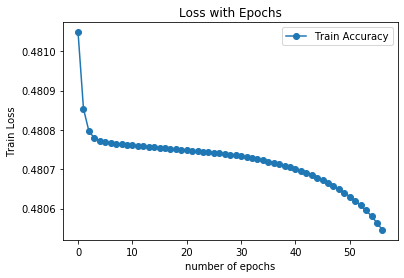

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Loss with Epochs")
x = np.arange(0,len(costs[5:]))
ax.plot(x, costs[5:], marker='o', label='Train Accuracy')
ax.set_xlabel("number of epochs")
ax.set_ylabel("Train Loss")

plt.legend()
#plt.savefig("accuracy_HiddenUnit_val20per.png", dpi=1000, bbox_inches='tight')
plt.show()

In [70]:
costs

[5.831782109502939,
 3.065637409541897,
 1.8247308746788262,
 1.5705342932734632,
 1.33022343238924,
 1.1285249107258797,
 1.0643045095099792,
 1.035211733200288,
 1.018805714862765,
 6.376557034638974,
 1.422657448017669,
 1.4211259379043941,
 1.419297906735625,
 1.4176605209953743,
 1.4166161084913558,
 1.416185709207088,
 1.4152965281422567,
 1.4146839345350188,
 1.4144074662583,
 1.4142618066732653,
 1.4140713474500968,
 1.4134148478899253,
 1.4131559125054791,
 1.412979612601874,
 1.4128589818155581,
 1.4127652801754333,
 1.412630967544444,
 1.412496660264301,
 1.4123353187531043]